In [1]:
# Nativos
import random as rn
import os
import sys
import gc

#calculo
import numpy as np
import pandas as pd
import scipy

import pandas as pd
import scorecardpy as sc

SEED = 29082013
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [2]:
x_train = pd.read_csv("X_train.csv")
x_valid = pd.read_csv("X_valid.csv")

y_train = pd.read_csv("y_train.csv")
y_valid = pd.read_csv("y_valid.csv")

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((51120, 60), (12781, 60), (51120, 1), (12781, 1))

In [3]:
def calcular_pesos(modelo):
    coef_model = pd.DataFrame(modelo.tvalues, columns=['t_value'])
    coef_model['t_value2'] = np.power(coef_model['t_value'],2)
    coef_model['total'] = sum(coef_model['t_value2'])
    coef_model['part'] = coef_model['t_value2'] / coef_model['total']
    coef_model['pesos'] = coef_model['part'] * 100
    return coef_model['pesos'].sort_values(ascending=True)

### >> Modleo mayor p-value

In [4]:
cols_aporte = [
 'Empleado',
 'Tiempo_empleo',
 'Saldo_cuenta',
 'Valor_prestamo',
 'Cuentas_otros',
 'Autocontrol',
 'Impulsividad',
 'Confianza' 
]

In [5]:
x_train['target'] = y_train.values
matriz_corr = x_train[cols_aporte + ['target']].corr(method='pearson')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,target
Empleado,1.00000,0.48055,0.00228,-0.00777,-0.00280,0.00654,-0.00507,0.00307,-0.00068
Tiempo_empleo,0.48055,1.00000,0.01015,-0.00205,-0.00453,0.00186,-0.00713,0.00550,0.00186
Saldo_cuenta,0.00228,0.01015,1.00000,-0.00130,0.00060,-0.00113,0.00471,-0.00429,-0.00690
Valor_prestamo,-0.00777,-0.00205,-0.00130,1.00000,0.00015,0.00992,-0.00262,0.00102,-0.00211
Cuentas_otros,-0.00280,-0.00453,0.00060,0.00015,1.00000,-0.00093,0.00341,-0.00164,0.00383
Autocontrol,0.00654,0.00186,-0.00113,0.00992,-0.00093,1.00000,0.00412,0.00735,-0.00478
Impulsividad,-0.00507,-0.00713,0.00471,-0.00262,0.00341,0.00412,1.00000,-0.00452,-0.00201
Confianza,0.00307,0.00550,-0.00429,0.00102,-0.00164,0.00735,-0.00452,1.00000,0.00093
target,-0.00068,0.00186,-0.00690,-0.00211,0.00383,-0.00478,-0.00201,0.00093,1.00000


In [6]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00690
Autocontrol,0.00478
Cuentas_otros,0.00383
Valor_prestamo,0.00211
Impulsividad,0.00201
Tiempo_empleo,0.00186
Confianza,0.00093
Empleado,0.00068


In [7]:
matriz_corr = x_train[cols_aporte + ['target']].corr(method='spearman')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,target
Empleado,1.00000,0.61398,0.00248,-0.00547,-0.00123,0.00558,-0.00528,0.00263,-0.00068
Tiempo_empleo,0.61398,1.00000,0.00249,-0.00161,-0.00478,0.00287,-0.00603,0.00498,0.00096
Saldo_cuenta,0.00248,0.00249,1.00000,0.00325,0.00055,-0.00083,0.00214,-0.00655,-0.00791
Valor_prestamo,-0.00547,-0.00161,0.00325,1.00000,0.00018,0.00950,-0.00224,0.00085,-0.00436
Cuentas_otros,-0.00123,-0.00478,0.00055,0.00018,1.00000,-0.00073,0.00404,-0.00097,0.00278
Autocontrol,0.00558,0.00287,-0.00083,0.00950,-0.00073,1.00000,0.00415,0.00759,-0.00407
Impulsividad,-0.00528,-0.00603,0.00214,-0.00224,0.00404,0.00415,1.00000,-0.00383,-0.00219
Confianza,0.00263,0.00498,-0.00655,0.00085,-0.00097,0.00759,-0.00383,1.00000,0.00042
target,-0.00068,0.00096,-0.00791,-0.00436,0.00278,-0.00407,-0.00219,0.00042,1.00000


In [8]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00791
Valor_prestamo,0.00436
Autocontrol,0.00407
Cuentas_otros,0.00278
Impulsividad,0.00219
Tiempo_empleo,0.00096
Empleado,0.00068
Confianza,0.00042


In [9]:
del x_train['target']

In [10]:
import statsmodels.api as sm

logit_model_2 = sm.Logit(y_train , x_train[cols_aporte])
result_2 = logit_model_2.fit()

Optimization terminated successfully.
         Current function value: 0.409955
         Iterations 6


In [11]:
#help(logit_model_2.fit)

In [12]:
pesos_ = pd.DataFrame(calcular_pesos(result_2)).reset_index()
pesos_

,index,pesos
0,Tiempo_empleo,0.077504
1,Cuentas_otros,0.450101
2,Saldo_cuenta,0.926233
3,Empleado,6.182634
4,Valor_prestamo,8.845750
5,Impulsividad,24.083078
6,Confianza,26.701109
7,Autocontrol,32.733590


In [13]:
pesos_.to_excel('pesos_originales.xlsx', index=False)

In [14]:
result_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: -0.007    
Dependent Variable: Incumplimiento   AIC:              41929.7943
Date:               2021-06-12 09:12 BIC:              42000.5298
No. Observations:   51120            Log-Likelihood:   -20957.   
Df Model:           7                LL-Null:          -20809.   
Df Residuals:       51112            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Empleado         -0.1950   0.0378  -5.1552 0.0000 -0.2691 -0.1208
Tiempo_empleo     0.0901   0.1562   0.5772 0.5638 -0.2159  0.3962
Saldo_cuenta     -2.1356   1.0703  -1.9953 0.0460 -4.2334 -0.0379
Valor_prestamo   -0.3790   0.0615  -6.1663 0.0000 -0.4995 -0.2585
Cuentas_otros    -0.1224   0.0880  -1.3909 0.1642 -0.2950  0.0501
Autocontrol      -1.0562   0.0890 -11.8619 0.0000 -1.2308 -0.8817
Impulsividad     -0.8860   0.0871 -10.1745 0.0000 -1.0567 -0.7154
Confianza        -0.9834   0.0918 -10.7132 0.0000 -1.1634 -0.8035
=================================================================

"""

In [15]:
import numpy as np
#prediciendo en base al modelo 
y_pred_prob_2_train = result_2.predict(x_train[cols_aporte])
y_pred_class_2_train = np.where(y_pred_prob_2_train < 0.5, 0 , 1)

y_pred_prob_2_valid = result_2.predict(x_valid[cols_aporte])
y_pred_class_2_valid = np.where(y_pred_prob_2_valid < 0.5, 0 , 1)

In [16]:
pd.Series(y_pred_class_2_train).value_counts()

0    51120
dtype: int64

In [17]:
pd.Series(y_pred_class_2_valid).value_counts()

0    12781
dtype: int64

<AxesSubplot:>

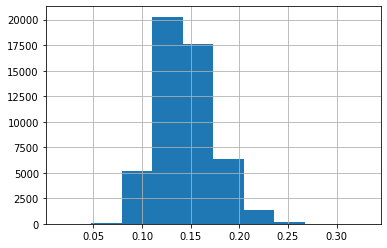

In [18]:
y_pred_prob_2_train.hist()

<AxesSubplot:>

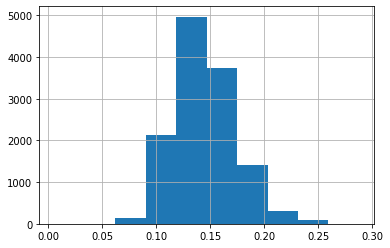

In [19]:
y_pred_prob_2_valid.hist()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

print("/"*25, 'TRAIN')
auc = roc_auc_score(y_train, y_pred_prob_2_train)
print("AUC: %1.3f" % auc)
print("GINI: %1.3f" % (2*auc-1))

print("/"*25, 'VALIDATION')
auc_2 = roc_auc_score(y_valid, y_pred_prob_2_valid)
print("AUC: %1.3f" % auc_2)
print("GINI: %1.3f" % (2*auc_2-1))

///////////////////////// TRAIN
AUC: 0.504
GINI: 0.009
///////////////////////// VALIDATION
AUC: 0.510
GINI: 0.020


In [21]:
print("/"*25, 'TRAIN')
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_2_train))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_2_train))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_2_train))
print("ACCURACY   : %1.8f" % accuracy_score(y_train, y_pred_class_2_train))

print("/"*25, 'VALIDATION')
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_2_valid))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_2_valid))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_2_valid))
print("accuracy_score   : %1.8f" % accuracy_score(y_valid, y_pred_class_2_valid))

///////////////////////// TRAIN
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000
ACCURACY   : 0.85884194
///////////////////////// VALIDATION
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000
accuracy_score   : 0.85885298


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### >>> RECALL

In [22]:
from scipy.optimize import differential_evolution


optimization_rec = differential_evolution(
    lambda c: -1*recall_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_rec

     fun: -1.0
 message: 'Optimization terminated successfully.'
    nfev: 122
     nit: 7
 success: True
       x: array([0.01298791])

In [23]:
corte_rec = optimization_rec['x'][0]
corte_rec

0.012987907660010789

In [24]:
y_pred_class_train_2_rec = np.where(y_pred_prob_2_train < corte_rec, 0 , 1)
y_pred_class_valid_2_rc = np.where(y_pred_prob_2_valid < corte_rec, 0 , 1)

In [25]:
pd.Series(y_pred_class_train_2_rec).value_counts()

1    51120
dtype: int64

In [26]:
pd.Series(y_pred_class_valid_2_rc).value_counts()

1    12780
0        1
dtype: int64

In [27]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_rec))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_rec))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_rec))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_rc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_rc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_rc))

///////////////////////// TRAIN
RECALL     : 1.00000000
EFECTIVIDAD: 0.14115806
F1 SCORE   : 0.24739440
///////////////////////// VALIDATION
RECALL     : 1.00000000
EFECTIVIDAD: 0.14115806
F1 SCORE   : 0.24739440


#### >>> EFECTIVIDAD

In [28]:
optimization_pre = differential_evolution(
    lambda c: -1*precision_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_pre

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision 

     fun: -0.3333333333333333
 message: 'Optimization terminated successfully.'
    nfev: 152
     nit: 9
 success: True
       x: array([0.28533042])

In [29]:
corte_pre = optimization_pre['x'][0]
corte_pre

0.2853304237081857

In [30]:
y_pred_class_train_2_pre = np.where(y_pred_prob_2_train < corte_pre, 0 , 1)
y_pred_class_valid_2_pre = np.where(y_pred_prob_2_valid < corte_pre, 0 , 1)

In [31]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_pre))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_pre))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_pre))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_pre))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_pre))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_pre))

///////////////////////// TRAIN
RECALL     : 0.00013858
EFECTIVIDAD: 0.33333333
F1 SCORE   : 0.00027705
///////////////////////// VALIDATION
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000


#### >>> AUC

In [48]:
optimization_auc = differential_evolution(
    lambda c: -1*roc_auc_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_auc

     fun: -0.5029950450246617
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 1
 success: True
       x: array([0.13374649])

In [49]:
corte_auc = optimization_auc['x'][0]
corte_auc

0.13374649447335152

In [50]:
y_pred_class_train_2_auc = np.where(y_pred_prob_2_train < corte_auc, 0 , 1)
y_pred_class_valid_2_auc = np.where(y_pred_prob_2_valid < corte_auc, 0 , 1)

In [51]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_auc))
print("accuracy_score    : %1.8f" % accuracy_score(y_train, y_pred_class_train_2_auc))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_auc))
print("accuracy_score   : %1.8f" % accuracy_score(y_valid, y_pred_class_valid_2_auc))

///////////////////////// TRAIN
RECALL     : 0.62333703
EFECTIVIDAD: 0.14233276
F1 SCORE   : 0.23174816
accuracy_score    : 0.41662754
///////////////////////// VALIDATION
RECALL     : 0.63192905
EFECTIVIDAD: 0.14461499
F1 SCORE   : 0.23536699
accuracy_score   : 0.42046788


In [52]:
pd.Series(y_pred_class_train_2_auc).value_counts()

1    31602
0    19518
dtype: int64

In [53]:
pd.Series(y_pred_class_valid_2_auc).value_counts()

1    7883
0    4898
dtype: int64

In [36]:
y_train.value_counts()

Incumplimiento
0                 43904
1                  7216
dtype: int64

In [37]:
y_valid.value_counts()

Incumplimiento
0                 10977
1                  1804
dtype: int64

In [38]:
y_train.shape

(51120, 1)

In [39]:
y_valid.shape

(12781, 1)